# T-SNE Principles & Algorithm

## Introduction to Gaussian Distribution PDFs

Let's start off by reviewing the PDF of a Gaussian distribution, which can be expressed as  $$ p(x) = {1\over \sqrt{2 \pi \sigma ^2}} exp ^ -{(x - \mu)^2 \over 2 \sigma^2} $$

Here, $ \mu $ represents the mean, and $ \sigma $ represents the standard deviation. 

Let's refamiliarize ourselves with the properties of this distribution. First, we'll import our necessary packages:

In [185]:
import numpy as np, math, matplotlib.pyplot as plt, pandas as pd, random
import numpy as Math
from sklearn.utils import shuffle
from mpl_toolkits.mplot3d import Axes3D
csv_file_path = "..\\Data\mnist_three_five_eight_two_zero.csv"

COLORS =['#12efff','#eee111','#eee00f','#e00fff','#123456','#abc222','#123fff','#1eff1f','#2edf4f','#2eaf9f','#22222f',
        '#eeeff1','#eee112','#00ef00','#aa0000','#0000aa','#000999','#32efff','#23ef68','#2e3f56','#7eef1f','#eeef11']

Now, let's set the mean of the normal distribution to **3** and its standard deviation to **2**. We'll plot this distribution across a space from -10 to 15:

In [186]:
mu = 3
sigma = 2
x = np.linspace(start = -10, stop = 15, num = 100)

Let's create our own function to calcuate the probability of finding a point at location $ x $ given this distribution $ N( \mu = 3, \sigma = 2)$, using the same PDF defined above:

In [187]:
def get_norm_probability(x, mu = 0, sigma = 1):
    
   return (1 / math.sqrt(2 * math.pi * sigma ** 2.0)) * math.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

Let's test it. What happens when $ x = 0 $ and we have $ \mu = 0, \sigma = 1$?

In [188]:
get_norm_probability(0)

0.3989422804014327

If we plug the same parameters into any online normal PDF calculator (such as [this one](https://www.easycalculation.com/statistics/normal-pdf.php), we'll see this is indeed the correct answer. Great! So it looks like our PDF function is working! Let's plot this function. We'll define a function to iterate from -10 to 15:

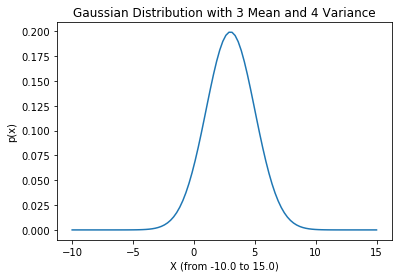

In [189]:
def iterate_over_x(x, **kwargs):
    if 'sigma' in kwargs and 'mu' in kwargs:
        return [get_norm_probability(i, mu=kwargs['mu'], sigma=kwargs['sigma']) for i in x]
    else:
        return [get_norm_probability(i) for i in x]

plt.plot(x, iterate_over_x(x, mu=3, sigma=2))
plt.xlabel("X (from {0} to {1})".format(min(x), max(x)))
plt.ylabel("p(x)")
plt.title("Gaussian Distribution with {0} Mean and {1} Variance".format(mu, sigma ** 2))
plt.show()

## Importing Our Data

The first task in any data preprocessing step is to visualize the raw data and see if any coherent patterns can be identified. Using the code below, one issue becomes immediately clear- human beings such as ourselves can visualize data in three dimensions. Yet what happens when our data contains more than 3 columns? In many workforce analytics datasets, the number of columns in our raw dataset can be over 100.

In [190]:
#creates a Numpy matrix after importing in your raw CSV file
data = pd.read_csv(csv_file_path).values

print("Data was successfully imported and cast as a Numpy matrix of shape ({0},{1})".
      format(data.shape[0],data.shape[1]))
# We'll truncate some of our data to make it more manageable! 
# We will work with only the first 1500 rows of our MNIST dataset, and cut out the first column (our number labels)
labels = data[:2000,0]
data = data[:2000,1:]

# find the data's shape
(n, d) = data.shape
print("The new shape of our truncated data is a {0} x {1} feature space matrix".format(n,d))


Data was successfully imported and cast as a Numpy matrix of shape (29199,785)
The new shape of our truncated data is a 2000 x 784 feature space matrix


What happens if we try to visualize this data?

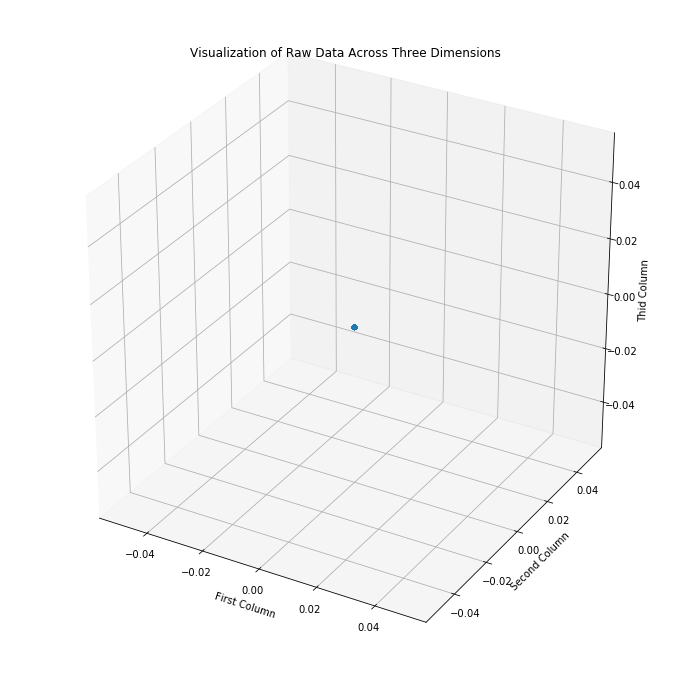

In [182]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel("First Column")
ax.set_ylabel("Second Column")
ax.set_zlabel("Thid Column")
plt.title("Visualization of Raw Data Across Three Dimensions")

plt.show()

That's a pretty pathetic-looking scatter plot. Why? The image itself has 700+ pixel dimensions, but for most of us, we're only able to visualize three of them at a time (those of you who are able to see across time, call me). 

## First Look at T-SNE

**T-SNE** stands for *t-Distributed Stochastic Neighbor Embedding*. Let's first start by understanding **SNE**, and taking a look at its inner workings. Here's the "workhorse" equation the algorithm uses:

$$ p_{j|i} = {exp({-||x_i - x_j||^2 \over 2 \sigma_i ^ 2}) \over \sum_{k \ne j} exp({-||x_i - x_k||^2 \over 2 \sigma_i ^ 2})  }$$

It looks complicated, but it's actually pretty simple. $ p_{j|i} $ is the probability of finding point `j` *given* that you are at point `i`.

Let's write our Python function for this. We'll need to a function first to calculate the **Euclidean distance** between two data points. Remember, this may not just be a two-dimensional surface! Our data is frequently in many (sometimes hundreds) of dimensions.

In [72]:
def calculate_euclidean_distance(a,b):
    difference = np.array(a) - np.array(b)
    return math.sqrt(np.dot(difference, difference))

#Test it with a 3-4-5 right triangle!
calculate_euclidean_distance([0,0],[3,4])

5.0

This works great for calculating an individual distance between two pairs of points, but imagine having to iterate through all sets of data points **twice** with two nested `for` loops? You can imagine it'd be quite time-consuming and verbose code-wise. Let's use an identity from linear algebra:

$$ ||x_i - x_j ||^2 = || x_i || ^2 + || x_j || ^ 2 - 2(x_i \cdot x_j)  $$ 

We also know that we can represent the points within this space's relationships with each other as a [Gramian matrix](https://en.wikipedia.org/wiki/Gramian_matrix). Within this Gramian matrix **$G$**, we can take a vector $g = diag(G)$.  This means that we can simplify the above identity to become 

$$ D = g1^T + 1g^T - 2G $$

where $ || x_i || ^2 $ is mapped to $ g1^T$ (the "magnitude" of each data point as a vector), $ || x_j || ^ 2 $ is mapped to $ 1g^T $, and $ 2(x_i \cdot x_j) $ is mapped to $ 2G $. Remember, here $G$ is (N x N) matrix, $g$ is a vector of size N, and $1$ is a N-sized vector of ones. 

Next, we find the equivalent of $ g1^T $ and $ 1g^T $ (note that since we are trying to find pairwise similarity distances, these two expressions evaluate to the same scalar value:


In [73]:
sum_X = np.sum(np.square(data), 1)
print("The sum along each row of the feature space is \n{0}".format(sum_X))

The sum along each row of the feature space is 
[4660913 6076175 6918899 ..., 5699427 6845557 5307416]


Now, we write the code for $ -2G $. Remember that the Gramian is a N x N matrix, so we should be getting a matrix of size N x N of all negative values:

In [74]:
two_G = -2 * np.dot(data, data.T)
print("The dot product of the data multiplied by two is \n{0}".format(two_G))

The dot product of the data multiplied by two is 
[[ -9321826  -4356502  -3580076 ...,  -4403522  -3811372  -3018014]
 [ -4356502 -12152350  -5614958 ...,  -5558302  -7602362  -4365296]
 [ -3580076  -5614958 -13837798 ...,  -5264802  -5179932  -4197170]
 ..., 
 [ -4403522  -5558302  -5264802 ..., -11398854  -4933392  -5020544]
 [ -3811372  -7602362  -5179932 ...,  -4933392 -13691114  -3416702]
 [ -3018014  -4365296  -4197170 ...,  -5020544  -3416702 -10614832]]


Combine these two parts, and you'll get the distance measure for each data point with respect to the other data points. Note that the diagonal values are 0, which suggests (intuitively) that the distance from point `i` to `i` is 0:

In [75]:
D = np.add(np.add(sum_X, two_G).T, sum_X)
print("The pairwise distance matrix for this feature space is \n{0}".format(D))

The pairwise distance matrix for this feature space is 
[[      0 6380586 7999736 ..., 5956818 7695098 6950315]
 [6380586       0 7380116 ..., 6217300 5319370 7018295]
 [7999736 7380116       0 ..., 7353524 8584524 8029145]
 ..., 
 [5956818 6217300 7353524 ...,       0 7611592 5986299]
 [7695098 5319370 8584524 ..., 7611592       0 8736271]
 [6950315 7018295 8029145 ..., 5986299 8736271       0]]


While we're here, we might as well initialize some other values we'll need later on:

In [76]:
#create a N x N matrix of zeroes for the P values
P = np.zeros((n,n))

# create a N x 1 matrix of beta values, initialized at one
beta = np.ones((n,1))

# start off with a perplexity of 30.0 (more details later)
perplexity = 5.0
logU = np.log(perplexity)

tolerance = 1e-5

To calculate the actual initial probability distributions, we'll multiply the square root of the variance by the negative of the row feature vector $D_i$, and then exponentiate this result. We then find make sure that we have valid properties by normalizing the probabilities $p_{j|i}$ so that they all sum to 1.

In [77]:
# for the sake of demonstration, let's set the first row of our D matrix to Di

Di = D[0,:]
P = np.exp(-Di.copy() * beta)
sumP = sum(P)
P = P / sumP
P

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


array([[ 0.0005,     nan,     nan, ...,     nan,     nan,     nan],
       [ 0.0005,     nan,     nan, ...,     nan,     nan,     nan],
       [ 0.0005,     nan,     nan, ...,     nan,     nan,     nan],
       ..., 
       [ 0.0005,     nan,     nan, ...,     nan,     nan,     nan],
       [ 0.0005,     nan,     nan, ...,     nan,     nan,     nan],
       [ 0.0005,     nan,     nan, ...,     nan,     nan,     nan]])

Uh oh. What do you see? A lot of `nan`s, right? We're taking the exponent of the negative a very large number (the pairwise distance), which is going to be an *extremely* small number. But don't worry. We essentially just set the value to 0, and every works fine in future iterations.

The **Shannon Entropy**'s relationship with perplexity can be defined as $ P = 2 ^ H $, where $P$ is the perplexity defined from user input. This means that 

$$ log(P) = H log(2) $$

$$ log(P) = H $$

$$ log(P) = \sum_j{p_{j|i} log_2{p_{j|i}}} $$

Therefore, we can write out the Python expression to calculate ** Shannon Entropy ** as a method called `Hbeta()`. Here, `beta` refers to $ 1 \over \sigma^2 $, and `D` refers to one row of the similarity distance matrix.

In [78]:
def Hbeta(D = np.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""
    
    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta);
    sumP = sum(P);
    
    #standardize P values
    P = P / sumP;
    
    #Shannon Entropy calculation
    H = -Math.sum(P * Math.log(P))

    #this condition is needed to deal with numerical underflows during the early iterations
    if math.isnan(H):
        H = 0
    
    return H, P;

Therefore, we're looking for a `H` value that will be as close as possible to the log of the perplexity we defined. What variable are we able to adjust to tweak the value for `H`? The answer is `beta` ($ 1 \over \sigma^2 $). We'll use a binary search method to find the right `beta` value, first casting a wide net by setting `betamax` to be $\infty $ and `betamin` to be $-\infty$. For each of the `tries`, if our calculated `H` value does not fall within the `tolerance` threshold for `logU` (the log of the ** perplexity **), we'll cut the range for `betamax` or `betamin` in half depending on whether `Hdiff` if positive or negative:

In [84]:
def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
	"""Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

	# Initialize some variables
	print("Computing pairwise distances...")
	(n, d) = X.shape;
	sum_X = Math.sum(Math.square(X), 1);
	D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
	P = Math.zeros((n, n));
	beta = Math.ones((n, 1));
	logU = Math.log(perplexity);

	# Loop over all datapoints
	for i in range(n):

		# Print progress (disabled to improve performance for larger datasets)
		#print("Computing P-values for point ", i, " of ", n, "...")

		# Compute the Gaussian kernel and entropy for the current precision
		betamin = -Math.inf;
		betamax =  Math.inf;
		Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
		(H, thisP) = Hbeta(Di, beta[i]);

		# Evaluate whether the perplexity is within tolerance
		Hdiff = H - logU;
		tries = 0;
		while Math.abs(Hdiff) > tol and tries < 50:

			# If not, increase or decrease precision
			if Hdiff > 0:
				betamin = beta[i].copy();
				if betamax == Math.inf or betamax == -Math.inf:
					beta[i] = beta[i] * 2;
				else:
					beta[i] = (beta[i] + betamax) / 2;
			else:
				betamax = beta[i].copy();
				if betamin == Math.inf or betamin == -Math.inf:
					beta[i] = beta[i] / 2;
				else:
					beta[i] = (beta[i] + betamin) / 2;

			# Recompute the values
			(H, thisP) = Hbeta(Di, beta[i]);
			Hdiff = H - logU;
			tries = tries + 1;

		# Set the final row of P
		P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

	# Return final P-matrix
	print("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)));
	return P;

Let's test our new function, which converts our high-dimensional data points `X` into a matrix of Gaussian neighbor probabilities `p`. Notice the difference between calling `x2p()` with `perplexity` equal to `5`, and another call with `perplexity` equal to `30` (ask yourself- what explains the uniform results you see when `perplexity = 30`?):

Let's combine all of this into one function:

In [80]:
def Hbeta(D = Math.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""
    
    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    
    # Below is the method that Maaten uses to calculate H. However, I've defined an alternative calculation
    # taken straight from the definition of Shannon Entropy. Their method is clearly better, since it avoids
    # numerical underflow conditions. However, I wasn't able to derive it mathematically, so I stuck with my
    # own version.
    
    #H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    
    P = P / sumP;
    H = -Math.sum(P * Math.log(P))
    
    if math.isnan(H):
        H = 0
    return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional 
    Gaussian has the same perplexity."""
    
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);
    
    # Loop over all datapoints
    for i in range(n):
        if i % 10 == 0:        
            print ("Computing P-values for point ", i, " of ", n, "...")
            
        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf;
        betamax =  Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy();
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i].copy();
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

    # Return final P-matrix
    print ("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)));
    return P;

x2p(data, perplexity=5)

Computing pairwise distances...
Computing P-values for point  0  of  2000 ...
Computing P-values for point  10  of  2000 ...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in multiply


Computing P-values for point  20  of  2000 ...
Computing P-values for point  30  of  2000 ...
Computing P-values for point  40  of  2000 ...
Computing P-values for point  50  of  2000 ...
Computing P-values for point  60  of  2000 ...
Computing P-values for point  70  of  2000 ...
Computing P-values for point  80  of  2000 ...
Computing P-values for point  90  of  2000 ...
Computing P-values for point  100  of  2000 ...
Computing P-values for point  110  of  2000 ...
Computing P-values for point  120  of  2000 ...
Computing P-values for point  130  of  2000 ...
Computing P-values for point  140  of  2000 ...
Computing P-values for point  150  of  2000 ...
Computing P-values for point  160  of  2000 ...
Computing P-values for point  170  of  2000 ...
Computing P-values for point  180  of  2000 ...
Computing P-values for point  190  of  2000 ...
Computing P-values for point  200  of  2000 ...
Computing P-values for point  210  of  2000 ...
Computing P-values for point  220  of  2000 ...


array([[  0.00000000e+00,   3.64009244e-07,   1.19621423e-10, ...,
          2.97010176e-06,   5.40980482e-10,   2.16493693e-08],
       [  4.29690818e-12,   0.00000000e+00,   1.74319286e-14, ...,
          1.05654721e-11,   1.48791223e-09,   1.27985181e-13],
       [  3.75912673e-16,   1.66099917e-14,   0.00000000e+00, ...,
          1.95424670e-14,   1.05267482e-17,   3.14048693e-16],
       ..., 
       [  3.76317647e-10,   1.10517440e-10,   5.27598856e-13, ...,
          0.00000000e+00,   1.56715337e-13,   3.27589171e-10],
       [  1.68803281e-15,   1.31668891e-08,   4.43723949e-18, ...,
          2.94873569e-15,   0.00000000e+00,   1.61022829e-18],
       [  3.32992724e-08,   2.53626879e-08,   4.42584625e-10, ...,
          1.58188186e-06,   2.60659045e-11,   0.00000000e+00]])

Let's now take a look at our cost function, which is provided by the ** Kullback-Leibler divergence**:

$$ C = \sum_i{KL(P_i || Q_i)} = \sum_i \sum_j {p_{j|i} log {p_{j|i} \over q_{j|i}}} $$

Here, $ P_i $ is the conditional probability distribution we just calculated, and $ Q_i $ is the same conditional distribution, but in our newly transformed lower-dimension space. We'll begin by initializing several of the parameters needed to conduct ** gradient descent ** on the cost function:

In [81]:
no_dims = 3 # The number of dimensions that we want our final low-dimensional data to be in

P = x2p(data, 1e-5, perplexity=25); # using our previous function to convert our original data to a P matrix

# Because of numerical overflow issues, we increase the magnitude of the row-wise vectors that comprise our P matrix.
# This adjustment is reversed later on.
P = P + Math.transpose(P);
P = P / Math.sum(P);
P = P * 4;
P = Math.maximum(P, 1e-12);

max_iter = 1000; # define the maximum number of iterations run our descent algorithm on
initial_momentum = 0.5; # our initial momentum definition
final_momentum = 0.8; #our final momentum definition
eta = 500; # our learning rate
min_gain = 0.01; # our minimum gain, to ensure we are not stuck in local minimas

Y = Math.random.randn(n, no_dims); # Y target matrix of final low-dimensional values (N x new_dimensions)
dY = Math.zeros((n, no_dims)); # gradient of Y, initialized to 0
iY = Math.zeros((n, no_dims));
gains = Math.ones((n, no_dims));

Computing pairwise distances...
Computing P-values for point  0  of  2000 ...
Computing P-values for point  10  of  2000 ...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in multiply


Computing P-values for point  20  of  2000 ...
Computing P-values for point  30  of  2000 ...
Computing P-values for point  40  of  2000 ...
Computing P-values for point  50  of  2000 ...
Computing P-values for point  60  of  2000 ...
Computing P-values for point  70  of  2000 ...
Computing P-values for point  80  of  2000 ...
Computing P-values for point  90  of  2000 ...
Computing P-values for point  100  of  2000 ...
Computing P-values for point  110  of  2000 ...
Computing P-values for point  120  of  2000 ...
Computing P-values for point  130  of  2000 ...
Computing P-values for point  140  of  2000 ...
Computing P-values for point  150  of  2000 ...
Computing P-values for point  160  of  2000 ...
Computing P-values for point  170  of  2000 ...
Computing P-values for point  180  of  2000 ...
Computing P-values for point  190  of  2000 ...
Computing P-values for point  200  of  2000 ...
Computing P-values for point  210  of  2000 ...
Computing P-values for point  220  of  2000 ...


The key takeaway here is expressed through the Pythonic statement `Y = Y + iY`. We are taking the old values for `Y` and applying a certain update to them. The updates are dependent upon two components:
1. The derivative of `Y` with respect to the **KL cost function**
2. The momentum and gain (introduced to help deal with issues of local minima and crowding

Gain is calculated here as essentially the product of the previous iteration's gain and three possible float values: 
1. **.2**, which occurs when the derivative with respect to a particular element $Y_{i,j}$ is positive but the value for the previous iteration of `iY` is negative (or vice versa)
2. **.8**, which occurs when the sign of the derivative with respect to a particular element $Y_{i,j}$ matches the sign of the value for `iY`.
3. **.01**, which occurs in the rare case when the gains computed are less than the minimum gain. 

Think of the concept of `gain` metaphorically as a driver trying to navigate a variety of different roads with varying levels of congestion. Whenever there's lots of changes in direction (`dY`'s sign doesn't match the previous iteration's update, then we make a small update. However, if the signs match, then we're probably driving on a relatively smooth, straight path and can take larger steps.

For each of the rows within `Y`, we begin calculating `sum_Y` and then reconstructing the lower-dimension `Q`:

In [82]:
sum_Y = Math.sum(Math.square(Y),1)
num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
num[range(n), range(n)] = 0; # converts the diagonals of Q from 1s to 0s
Q = num / Math.sum(num); # standardizes the values by the sum
Q = Math.maximum(Q, 1e-12); # establishes a minimum baseline for Q for numerical underflow errors
print("Our new Q: \n{0}".format(Q))

Our new Q: 
[[  1.00000000e-12   6.78411674e-07   1.72920384e-07 ...,   2.48397634e-07
    3.53382868e-07   3.26744635e-07]
 [  6.78411674e-07   1.00000000e-12   1.36648850e-07 ...,   2.69923063e-07
    3.65078674e-07   4.75054780e-07]
 [  1.72920384e-07   1.36648850e-07   1.00000000e-12 ...,   2.74555483e-07
    1.65217509e-07   1.59961400e-07]
 ..., 
 [  2.48397634e-07   2.69923063e-07   2.74555483e-07 ...,   1.00000000e-12
    1.67755751e-07   6.18196103e-07]
 [  3.53382868e-07   3.65078674e-07   1.65217509e-07 ...,   1.67755751e-07
    1.00000000e-12   1.91837839e-07]
 [  3.26744635e-07   4.75054780e-07   1.59961400e-07 ...,   6.18196103e-07
    1.91837839e-07   1.00000000e-12]]


Now that we have out `P` and `Q` matrices, it's time to start calculating the gradient `dY`, which is defined by Maaten and Hinton as 

$$ {dC \over dy_i} = {2 \sum_j{(p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(y_i - y_j)}}$$

We can write this in Python using linear algebra as the following:

In [83]:
PQ = P - Q;
for i in range(n):
    dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
    
print("Our new values for dY: \n {0}".format(dY))

Our new values for dY: 
 [[ -1.26206755e-04  -1.67956305e-05  -1.67511829e-04]
 [ -3.40089404e-04   2.07180588e-04   1.43748647e-04]
 [  1.35796103e-04   1.83482806e-04  -1.99693200e-04]
 ..., 
 [  1.22526474e-04   6.04046115e-04   1.13991047e-04]
 [  3.51663182e-05  -4.04104981e-05   9.38434241e-05]
 [ -9.82537984e-06   2.03223300e-04   1.35897583e-04]]


All that's left now is to calculate the update `iY` value:

In [85]:
current_iteration = 10 # set a sample value to demosntrate what a particular iteration's update might look like

# Perform the update
if current_iteration < 20:
    momentum = initial_momentum
else:
    momentum = final_momentum
    
gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
gains[gains < min_gain] = min_gain;
iY = momentum * iY - eta * (gains * dY);
print("Our final updates for the {0}th iteration are \n {1}".format(current_iteration, iY))

Our final updates for the 10th iteration are 
 [[ 0.0504827   0.00671825  0.06700473]
 [ 0.13603576 -0.12430835 -0.08624919]
 [-0.08147766 -0.11008968  0.07987728]
 ..., 
 [-0.07351588 -0.36242767 -0.06839463]
 [-0.02109979  0.0161642  -0.05630605]
 [ 0.00393015 -0.12193398 -0.08153855]]


We are almost there! The last step is to calculate the new value for `Y`:

In [86]:
Y = Y + iY;

# Maaten applies a scaling function after each iteration as well to ensure that Y does not experience numerical overflow
# or underflow issues
Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));
Y

array([[-1.10472148,  0.60185254, -0.28085693],
       [-0.92132151,  0.47004813,  0.33695075],
       [ 0.74230323,  1.18486516, -1.2099041 ],
       ..., 
       [-0.02719775,  1.54388531,  0.05088858],
       [-0.20792926, -0.40441327, -0.07236405],
       [-0.57357657,  1.47788602,  0.56430337]])

Let's take a look at how this factors into our cost function:

In [60]:
C = Math.sum(P * Math.log(P / Q))
print("Looks like our cost at iteration {0} is {1}".format(current_iteration, C))

Looks like our cost at iteration 10 is 11.80164593933966


Before we run the whole thing, sometimes we might even need to reduce the dimensions further before feeding our data into t-SNE. Therefore, we'll define a quick ** PCA (Principle Component Analysis) ** function to handle this intermediate dimensionality reduction step:

In [100]:
def pca(X = Math.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""
    
    print ("Preprocessing the data using PCA...")
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:,0:no_dims]);
    print ("Dimensions reduced from {0} to {1}".format(d, no_dims))
    return Y;

We'll plug all of this into our new **`tsne`** function and see how it runs:

In [198]:
def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 20.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""
    
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.");
        return -1;
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.");
        return -1;
    
    # Initialize variables
    X = pca(X, initial_dims).real;
    (n, d) = X.shape;
    max_iter = 1000;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    #initialize an empty list of historical errors for performance tracking
    C_history = []
    
    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4; # early exaggeration
    P = Math.maximum(P, 1e-12);
    
    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);
        
        if iter % 10 == 0:
            print("On iteration {0}".format(iter))
        
        # Compute gradient
        PQ = P - Q;
        for i in range(n):
            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
            
        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        C = Math.sum(P * Math.log(P / Q));
        C_history.append(C)

        # Stop lying about P-values (by this point, all risks with underflow should be eliminated!)
        if iter == 100:
            P = P / 4;
        
        

    # Return solution
    return Y, C_history;

Now, we'll run the entire thing. Note- sometimes this can take quite a long time, especially if you have a lot of dimensions! In order to reduce runtime, you can set the number of initial_dimensions (the output of your PCA) to a lower number. This means that your T-SNE algorithm will won't have to store as much data. 

In [199]:
Y, C_history = tsne(data, initial_dims=20, no_dims=3)

Preprocessing the data using PCA...
Dimensions reduced from 784 to 20
Computing pairwise distances...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in multiply


Mean value of sigma:  458.068195687
On iteration 0
On iteration 10
On iteration 20
On iteration 30
On iteration 40
On iteration 50
On iteration 60
On iteration 70
On iteration 80
On iteration 90
On iteration 100
On iteration 110
On iteration 120
On iteration 130
On iteration 140
On iteration 150
On iteration 160
On iteration 170
On iteration 180
On iteration 190
On iteration 200
On iteration 210
On iteration 220
On iteration 230
On iteration 240
On iteration 250
On iteration 260
On iteration 270
On iteration 280
On iteration 290
On iteration 300
On iteration 310
On iteration 320
On iteration 330
On iteration 340
On iteration 350
On iteration 360
On iteration 370
On iteration 380
On iteration 390
On iteration 400
On iteration 410
On iteration 420
On iteration 430
On iteration 440
On iteration 450
On iteration 460
On iteration 470
On iteration 480
On iteration 490
On iteration 500
On iteration 510
On iteration 520
On iteration 530
On iteration 540
On iteration 550
On iteration 560
On ite

Let's plot the progression of the cost across the various iterations:

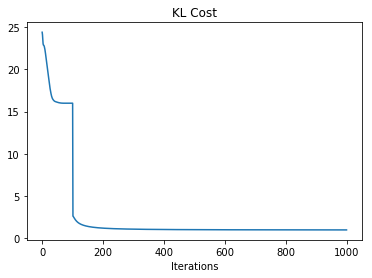

In [200]:
plt.plot(range(len(C_history)),C_history)
plt.title("KL Cost")
plt.xlabel("Iterations")
plt.show()

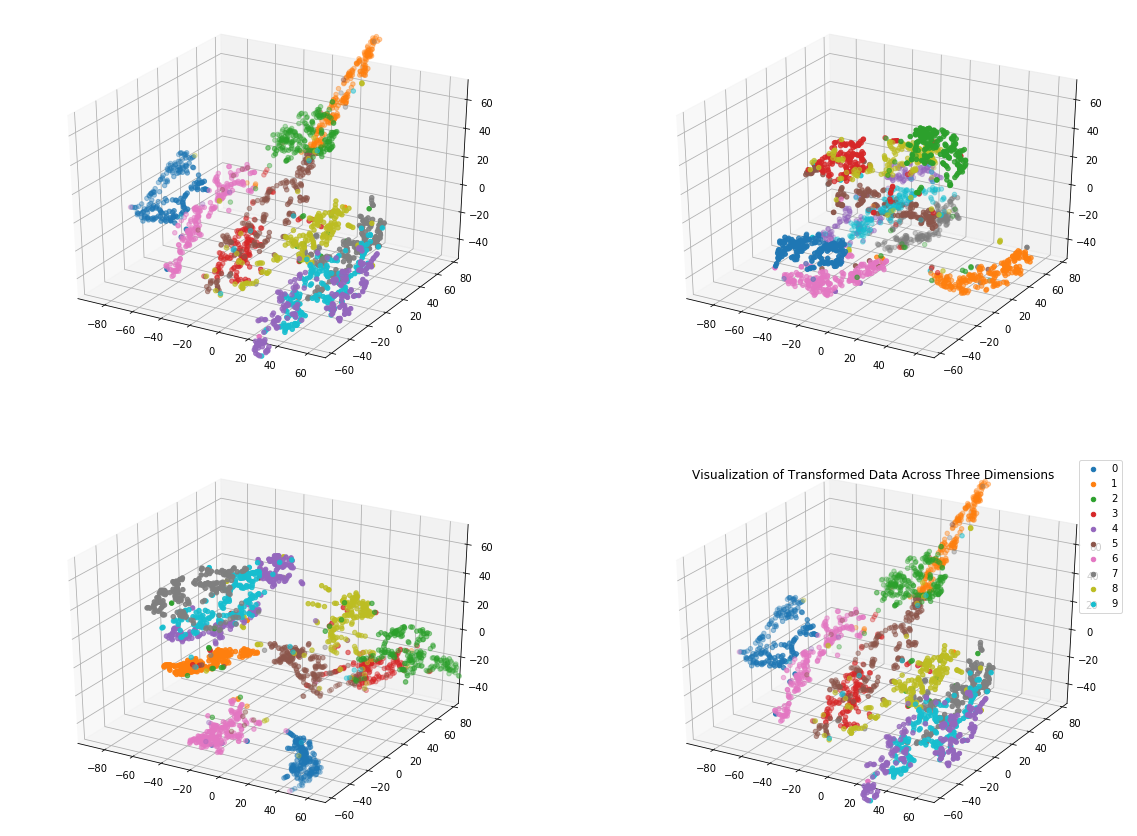

In [206]:
COLORS = shuffle(np.array(COLORS))
unique = list(set(labels))
f = plt.figure(figsize=(20,15))
ax_a = f.add_subplot(221, projection='3d')
ax_b = f.add_subplot(222, projection='3d')
ax_c = f.add_subplot(223, projection='3d')
ax_d = f.add_subplot(224, projection='3d')

x = list(Y[:,0])
y = list(Y[:,1])
z = list(Y[:,2])

plt.title("Visualization of Transformed Data Across Three Dimensions")

plt.axis('tight')

for i, u in enumerate(unique):
    xi = [x[j] for j in range(len(x)) if labels[j] == u]
    yi = [y[j] for j in range(len(y)) if labels[j] == u]
    zi = [z[j] for j in range(len(z)) if labels[j] == u]
    
    Xs = [xi, yi, zi]
    Ys = [yi, xi, zi]
    Zs = [yi, zi, xi]
    
    for k, axis in enumerate([ax_a, ax_b, ax_c, ax_d]):
        
        if k == 4:
            Xs = [xi, yi, zi]
            Ys = [yi, xi, zi]
            Zs = [zi, xi, yi]
        
        axis.scatter(Xs[k % 3], Ys[k % 3], Zs[k % 3], COLORS[i], label=str(u), marker="o")
        axis.set_xlim([np.percentile(x, 0.2), np.percentile(x, 99)])
        axis.set_ylim([np.percentile(y, 0.2), np.percentile(y, 99)])
        axis.set_zlim([np.percentile(z, 0.2), np.percentile(z, 99)])
plt.legend()
plt.show()